<a href="https://colab.research.google.com/github/Balenm/miniVGG/blob/main/Mini_VGG_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Binary Classification of Animal and Non-Animal Images using Mini-VGG Model

Installing relevant libraries:

In [ ]:
%%capture
!pip install torchmetrics
!pip install torchinfo

Importing libraries:

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchinfo import summary
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

Configuring the device to use:

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

A function to change the labels:

In [ ]:
def map_labels(label):
    if label in [0, 1, 8, 9]:  # 'airplane', 'automobile', 'ship', 'truck'
        return 1  # Non-Animal
    else:
        return 0  # Animal

Downloading the dataset:

In [ ]:
train = datasets.CIFAR10(root = '/content/Data',
                         train = True,
                         download = True,
                         transform = ToTensor(),
                         target_transform = None
                       )
test = datasets.CIFAR10(root = '/content/Data',  # Extracting the test set
                         train = False,
                         download = True,
                         transform = ToTensor(),
                         target_transform = None
                       )


train_labels = [map_labels(label) for label in train.targets]
test_labels = [map_labels(label) for label in test.targets]

#Override the targets attribute with modified labels
train.targets = train_labels
test.targets = test_labels

#Changing the classes (outputs) to two categories
train.classes = ['Animal', 'Non-Animal']
test.classes = ['Animal', 'Non-Animal']




train_size = int(0.8 * len(train))  # 80% for training
val_size = len(train) - train_size  # Remaining 20% for validation
train, validation = random_split(train, [train_size, val_size]) # Extracting the train and validation sets

100%|██████████| 170498071/170498071 [00:10<00:00, 15597499.20it/s]


Extracting /content/Data/cifar-10-python.tar.gz to /content/Data
Files already downloaded and verified


Checking the train, test and validation size:

In [ ]:
print(f"Training size: {len(train)} | Test Size: {len(test)} | Vlidation Size: {len(validation)}")

Training size: 40000 | Test Size: 10000 | Vlidation Size: 10000


Showing a sample of 16 images:

<ipython-input-8-1c6023bf3d9e>:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  plt.imshow(image.T)


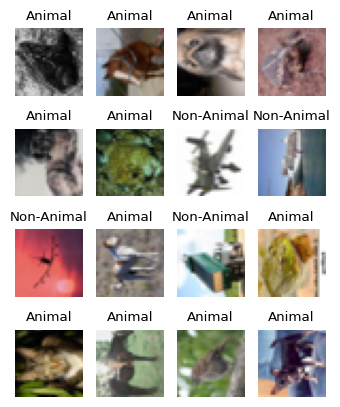

In [ ]:
torch.manual_seed(42)
class_names = train.dataset.classes
fig = plt.figure(figsize=(4,5))
plt.rcParams.update({'font.size': 8})
for i in range(1, 17):
  random_indx= torch.randint(0, len(train), size = [1]).item()
  image, label = train[random_indx]
  fig.add_subplot(4,4,i)
  plt.imshow(image.T)
  plt.title(class_names[label])
  plt.axis(False)

Transfering the data into a dataloader which helps to turn the data into batches:

In [ ]:
train_set = DataLoader(dataset=train,
                       batch_size=32,
                       shuffle=True
)

test_set = DataLoader(dataset=test,
                       batch_size=32,
                       shuffle=False
)

validation_set = DataLoader(dataset=validation,
                       batch_size=32,
                       shuffle=False
)

Checking the train, test, and validation batch sizes:

In [ ]:
len(train_set), len(test_set), len(validation_set)

(1250, 313, 313)

Creating the mini-VGG Model:

License: Wang, Zijie J., et al. “CNN 101: Interactive Visual Learning for Convolutional Neural Networks.” Extended Abstracts of the 2020 CHI Conference on Human Factors in Computing Systems, 25 Apr. 2020, arxiv.org/pdf/2001.02004.pdf,

In [ ]:
class AnimalClassifier_MiniVGG(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super(AnimalClassifier_MiniVGG, self).__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(input_shape,
                      hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units,
                      hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units,
                      hidden_units,
                      kernel_size=3,
                      stride=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units,
                      hidden_units,
                      kernel_size=3,
                      stride=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units , output_shape),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier_fc(x)
        return x.squeeze()


# Setting up the model
input_shape = 3  # RGB channels
hidden_units = 8 # Neurons
output_shape = 1  # Binary classification
mini_VGG_model = AnimalClassifier_MiniVGG(input_shape, hidden_units, output_shape)

Printing a summary of the model and parameters:

In [ ]:
summary(mini_VGG_model, input_size=[1, 3, 32, 32])

Layer (type:depth-idx)                   Output Shape              Param #
AnimalClassifier_MiniVGG                 --                        --
├─Sequential: 1-1                        [1, 8, 16, 16]            --
│    └─Conv2d: 2-1                       [1, 8, 32, 32]            224
│    └─ReLU: 2-2                         [1, 8, 32, 32]            --
│    └─Conv2d: 2-3                       [1, 8, 32, 32]            584
│    └─ReLU: 2-4                         [1, 8, 32, 32]            --
│    └─MaxPool2d: 2-5                    [1, 8, 16, 16]            --
├─Sequential: 1-2                        [1, 8, 1, 1]              --
│    └─Conv2d: 2-6                       [1, 8, 6, 6]              584
│    └─ReLU: 2-7                         [1, 8, 6, 6]              --
│    └─Conv2d: 2-8                       [1, 8, 2, 2]              584
│    └─ReLU: 2-9                         [1, 8, 2, 2]              --
│    └─MaxPool2d: 2-10                   [1, 8, 1, 1]              --
├─Sequentia

Setting up the loss and optimizer:

In [ ]:
# Setup loss and optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(params=mini_VGG_model.parameters(),
                             lr=0.1)

Setting up the train and test steps:

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred.to(torch.float), y.to(torch.float))
        train_loss += loss
        train_acc += accuracy_fn(y_true=y.to(torch.float), y_pred=y_pred.to(torch.float))

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Loss and accuracy per epoch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f}%")

    return train_loss , train_acc


##Defining

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred.to(torch.float), y.to(torch.float))
            test_acc += accuracy(y_true=y.to(torch.float), y_pred=test_pred.to(torch.float))

        # Getting percentages and printing the results
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.3f}    | Test accuracy: {test_acc:.2f}%\n")

        return test_loss, test_acc

def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, torch.round(y_pred)).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

Running the epochs on the train and test datasets:

In [ ]:
from timeit import default_timer as timer
from tqdm.auto import tqdm
start_time = timer()

train_loss_ = []
train_accuracy_ = []
test_loss_ = []
test_accuracy_ = []

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")
    tr_loss, tr_accuracy = train_step(data_loader=train_set,
        model=mini_VGG_model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy,
        device=device
    )

    te_loss, te_accuracy = test_step (data_loader=test_set,
        model=mini_VGG_model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy,
        device=device
    )
    print("___________________________________________________")

    ##Appending the loss and accuracy for each epoch
    train_loss_.append(tr_loss.detach().cpu())
    train_accuracy_.append(tr_accuracy)
    test_loss_.append(te_loss)
    test_accuracy_.append(te_accuracy)

end_time = timer()
total_time = end_time - start_time
print (f"Total time taken: {total_time}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Train loss: 0.66966 | Train accuracy: 60.01750%
Test loss: 0.595    | Test accuracy: 61.47%

___________________________________________________
Epoch: 1
Train loss: 0.44987 | Train accuracy: 79.11250%
Test loss: 0.409    | Test accuracy: 81.24%

___________________________________________________
Epoch: 2
Train loss: 0.33800 | Train accuracy: 85.71500%
Test loss: 0.297    | Test accuracy: 87.77%

___________________________________________________
Epoch: 3
Train loss: 0.30935 | Train accuracy: 87.14500%
Test loss: 0.317    | Test accuracy: 86.18%

___________________________________________________
Epoch: 4
Train loss: 0.29114 | Train accuracy: 88.00000%
Test loss: 0.281    | Test accuracy: 88.31%

___________________________________________________
Epoch: 5
Train loss: 0.27205 | Train accuracy: 88.90000%
Test loss: 0.253    | Test accuracy: 89.84%

___________________________________________________
Epoch: 6
Train loss: 0.26335 | Train accuracy: 89.33250%
Test loss: 0.244   

Plotting the loss and accuracy curves:

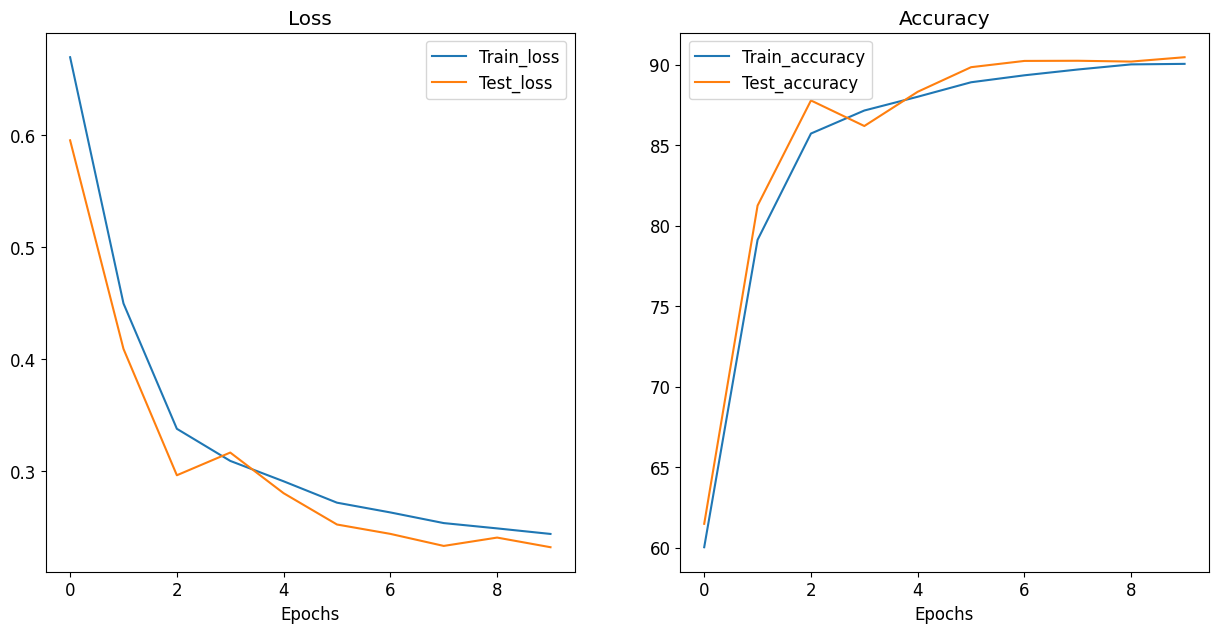

In [ ]:
epochs = range(len(train_loss_))
plt.figure(figsize=(15, 7))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_, label='Train_loss')
plt.plot(epochs, torch.tensor(test_loss_, device = 'cpu') , label='Test_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_, label='Train_accuracy')
plt.plot(epochs, test_accuracy_, label='Test_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

Predicted vs Ground-Truth Images:

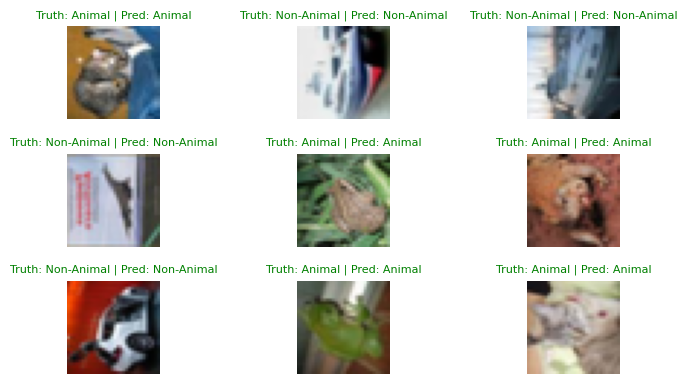

In [ ]:
images, labels = next(iter(test_set))

images = images.to(device)
labels = labels.to(device)

mini_VGG_model.eval()  # Put the model in evaluation mode
with torch.no_grad():  # Disable gradient calculation
    probabilities = mini_VGG_model(images)

predicted_labels = torch.round(probabilities).tolist()

plt.figure(figsize=(8,4))
for i in range(9):  # Iterate over the first 9 images

    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].squeeze().T.cpu(), cmap="gray")

    pred_label = "Non-Animal" if predicted_labels[i] == 1 else "Animal"
    truth_label = "Non-Animal" if labels[i] == 1 else "Animal"

    title_text = f"Truth: {truth_label} | Pred: {pred_label}"

    # Check for equality and change title color accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=8, color="g")
    else:
        plt.title(title_text, fontsize=8, color="r")
    plt.axis(False)

plt.tight_layout()
plt.show()

Calculating and plotting the confusion matrix

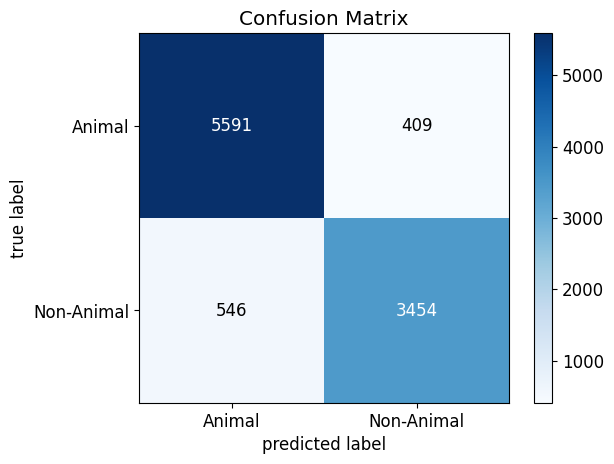

In [ ]:
probabilities = []
targets = []

mini_VGG_model.eval()
with torch.no_grad():
    for images, labels in test_set:
        probabilities_batch = mini_VGG_model(images.to(device))
        probabilities.append(probabilities_batch)
        targets.append(labels)

# Concatenate the predictions and targets from all batches
probabilities = torch.cat(probabilities)
targets = torch.cat(targets)

# Setting up confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=2, task='binary').to(device)
confmat = confmat(preds=probabilities, target=targets).to(device)

#Ploting the Confusion Matrix
plt.rcParams.update({'font.size': 12})
fig, ax = plot_confusion_matrix(
    confmat.cpu().numpy(),
    colorbar=True,
    )
ax.set_title("Confusion Matrix")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Animal", "Non-Animal"])
ax.set_yticklabels(["Animal", "Non-Animal"])
plt.show()

Computing the overall accuracy, precision, recall and F1-score:

In [ ]:
predictions = torch.round(probabilities).numpy()
labels = targets.numpy()

accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
f1 = f1_score(labels, predictions)

print(f"Accuracy: %{accuracy*100:.2f} | Precesion: %{precision*100:.2f} | Recall: %{recall*100:.2f} | F1 Score: %{f1*100:.2f}")

Accuracy: %90.45 | Precesion: %89.41 | Recall: %86.35 | F1 Score: %87.85
